In [ ]:
!wget https://datasets.cellxgene.cziscience.com/4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad

In [ ]:
!pip install -q scanpy[leiden] harmonypy symphonypy 2>/dev/null

In [ ]:
!pip install --user scikit-misc

In [ ]:
!pip install sccoda

In [5]:
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import sccoda.datasets as scd
from sccoda.util import cell_composition_data as dat
from scipy.stats import ttest_ind
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz
from statsmodels.stats.multitest import multipletests
warnings.filterwarnings('ignore')

In [6]:
adata = sc.read_h5ad('4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad', backed='r')

Делаем subsampling:

In [8]:
print(adata.obs['self_reported_ethnicity'].unique())

['Asian', 'European American', 'African American', 'Hispanic or Latin']
Categories (4, object): ['African American', 'European American', 'Hispanic or Latin', 'Asian']


In [9]:
print(adata.obs['disease'].unique())

['normal', 'systemic lupus erythematosus']
Categories (2, object): ['systemic lupus erythematosus', 'normal']


In [10]:
np.random.seed(8)

sle_mask = adata.obs['disease'] == 'systemic lupus erythematosus'

sle_donors_info = adata.obs.loc[sle_mask, ['donor_id', 'self_reported_ethnicity']]

asian_donors = sle_donors_info.loc[
    sle_donors_info['self_reported_ethnicity'] == 'Asian', 'donor_id'
].unique()
european_donors = sle_donors_info.loc[
    sle_donors_info['self_reported_ethnicity'] == 'European American', 'donor_id'
].unique()

selected_asian = np.random.choice(asian_donors, size=6, replace=False)

selected_european = np.random.choice(european_donors, size=6, replace=False)

selected_donors = list(selected_asian) + list(selected_european)

combined_mask = (adata.obs['disease'] == 'systemic lupus erythematosus') & (adata.obs['donor_id'].isin(selected_donors))

adata_filtered = adata[combined_mask].to_memory()

print(f"\nFinal filtered dataset (SLE patients only): {adata_filtered.shape[0]:,} cells")
print(f"Number of selected donors: {len(selected_donors)}")
print(f"Filtered dataset is in memory: {not adata_filtered.isbacked}")


Final filtered dataset (SLE patients only): 68,449 cells
Number of selected donors: 12
Filtered dataset is in memory: True


In [12]:
def perform_qc_on_raw(adata_filtered):

    X = adata_filtered.raw.X
    gene_names = adata_filtered.raw.var_names

    if issparse(X):
        print("Data is sparse matrix")
        n_counts = X.sum(axis=1).A1
        n_genes = (X > 0).sum(axis=1).A1
    else:
        print("Data is dense matrix")
        n_counts = X.sum(axis=1)
        n_genes = (X > 0).sum(axis=1)

    adata_filtered.obs['n_counts'] = n_counts
    adata_filtered.obs['n_genes'] = n_genes

    print(f"Total cells: {adata_filtered.n_obs:,}")
    print(f"Median counts per cell: {np.median(n_counts):.0f}")
    print(f"Median genes per cell: {np.median(n_genes):.0f}")
    return adata_filtered

adata_filtered = perform_qc_on_raw(adata_filtered)

Data is sparse matrix
Total cells: 68,449
Median counts per cell: 1815
Median genes per cell: 658


In [13]:
def get_pct_mito(adata, use_raw=True):

    if use_raw and hasattr(adata, 'raw') and adata.raw is not None:
        X = adata.raw.X
        var_names = adata.raw.var_names
    else:
        X = adata.X
        var_names = adata.var_names

    var_names_str = [str(gene) for gene in var_names]
    mito_genes = [gene for gene in var_names_str if gene.upper().startswith('ENSG000002')]

    print(f"Found {len(mito_genes)} mitochondrial genes")

    if len(mito_genes) == 0:
        print("Warning: No mitochondrial genes found with ENSG000002 pattern")
        return np.zeros(adata.n_obs), []

    mito_indices = [i for i, gene in enumerate(var_names_str) if gene in mito_genes]

    if issparse(X):
        total_counts = X.sum(axis=1).A1
        mito_counts = X[:, mito_indices].sum(axis=1).A1
    else:
        total_counts = X.sum(axis=1)
        mito_counts = X[:, mito_indices].sum(axis=1)

    pct_mito = np.zeros_like(total_counts, dtype=np.float32)
    non_zero = total_counts > 0
    pct_mito[non_zero] = (mito_counts[non_zero] / total_counts[non_zero]) * 100

    return pct_mito, mito_genes

pct_mito_values, mito_genes = get_pct_mito(adata_filtered)

# Add to adata_filtered
adata_filtered.obs['pct_mito'] = pct_mito_values

Found 12958 mitochondrial genes


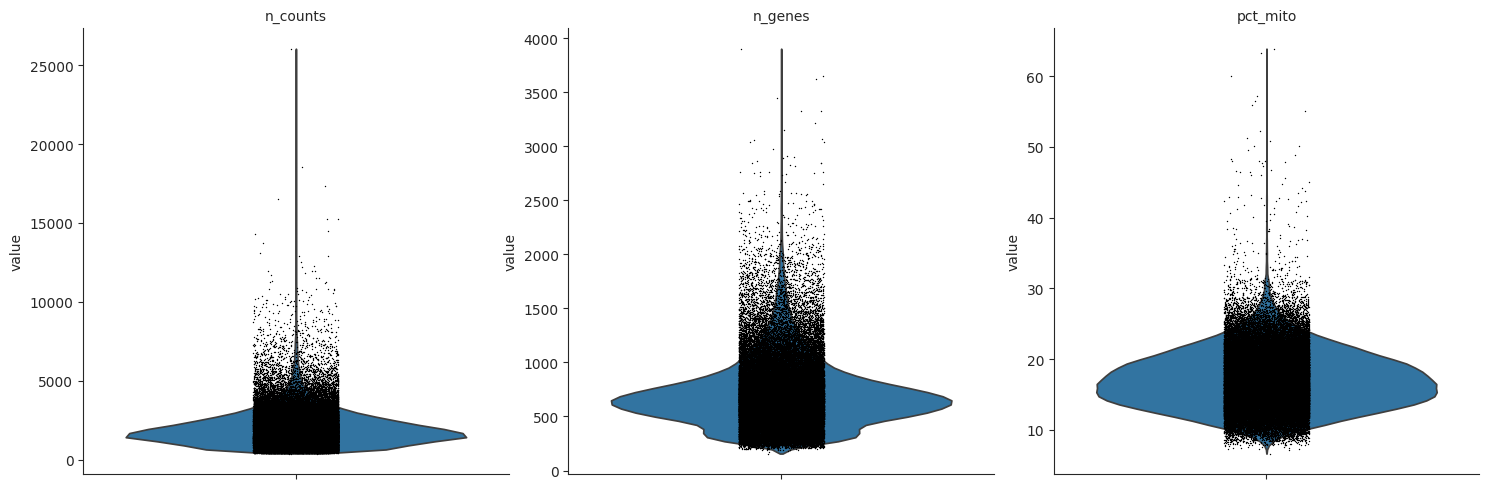

In [14]:
sc.pl.violin(adata_filtered, keys=["n_counts", "n_genes",
                          "pct_mito"], multi_panel=True)

In [15]:
print(f"Before cell filtering: {adata_filtered.shape[0]:,} cells")
sc.pp.filter_cells(adata_filtered, min_genes=100)
print(f"After cell filtering (min_genes=100): {adata_filtered.shape[0]:,} cells")

print(f"\nBefore gene filtering: {adata_filtered.shape[1]:,} genes")
sc.pp.filter_genes(adata_filtered, min_cells=10)
print(f"After gene filtering (min_cells=10): {adata_filtered.shape[1]:,} genes")

mito_col = None
for col in ['pct_counts_mt', 'pct_mito', 'pct_counts_mito']:
    if col in adata_filtered.obs.columns:
        mito_col = col
        break

print(f"Before mitochondrial filtering: {adata_filtered.shape[0]:,} cells")

low_mito_mask = adata_filtered.obs[mito_col] < 20

cells_removed = (~low_mito_mask).sum()
print(f"Cells to remove (mito >= 20%): {cells_removed:,}")

adata_filtered = adata_filtered[low_mito_mask, :]
print(f"After mitochondrial filtering: {adata_filtered.shape[0]:,} cells")


Before cell filtering: 68,449 cells
After cell filtering (min_genes=100): 27,286 cells

Before gene filtering: 30,172 genes
After gene filtering (min_cells=10): 1,889 genes
Before mitochondrial filtering: 27,286 cells
Cells to remove (mito >= 20%): 2,658
After mitochondrial filtering: 24,628 cells


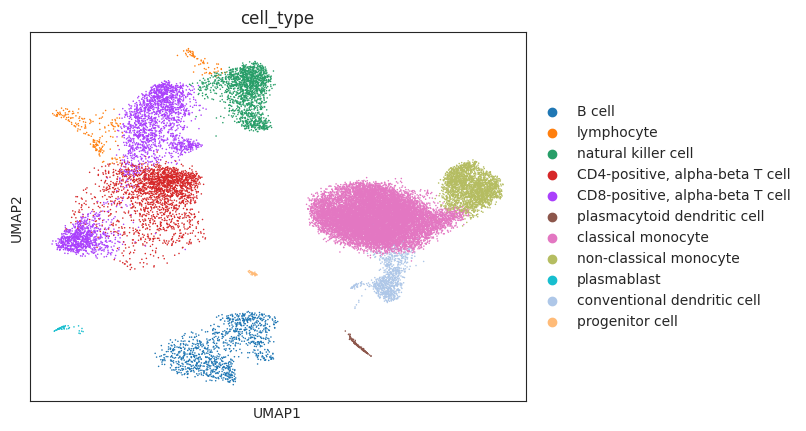

In [16]:
sc.pl.umap(adata_filtered, color='cell_type')

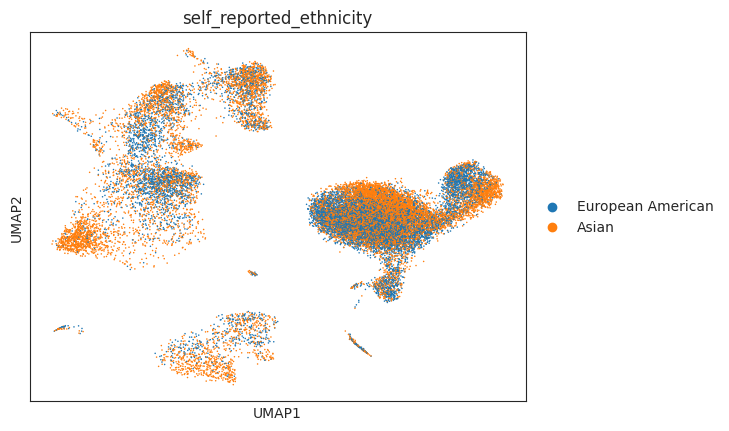

In [17]:
sc.pl.umap(adata_filtered, color='self_reported_ethnicity')

Skipping manual annotation...

Using pre-annotated cell types for research

In [18]:
if all(col in adata_filtered.obs.columns for col in ['donor_id', 'self_reported_ethnicity', 'cell_type']):
    cell_counts_final = adata_filtered.obs.groupby(
        ['donor_id', 'self_reported_ethnicity', 'cell_type']
    ).size().unstack(fill_value=0)

    cell_counts_final.to_csv('cell_counts_author_annotated.csv')

    adata_filtered.write('adata_annotated.h5ad', compression='gzip')

In [19]:
cell_counts = adata_filtered.obs.groupby(
    ['donor_id', 'self_reported_ethnicity', 'cell_type']
).size().unstack(fill_value=0)

cell_counts = cell_counts.reset_index()

In [20]:
required_columns = ['donor_id', 'self_reported_ethnicity', 'cell_type']
missing_columns = [col for col in required_columns if col not in adata_filtered.obs.columns]

if missing_columns:
    print(f"ОШИБКА: Отсутствуют колонки: {missing_columns}")
    print("Доступные колонки в adata_subsample.obs:")
    print(list(adata_filtered.obs.columns))
else:
    cell_counts = adata_filtered.obs.groupby(['donor_id', 'self_reported_ethnicity', 'cell_type']).size().unstack(fill_value=0)

    cell_counts = cell_counts.reset_index()
    print(cell_counts['self_reported_ethnicity'].value_counts())

    cell_counts['total_cells'] = cell_counts.iloc[:, 2:].sum(axis=1)
    print(f"\nМинимальное количество клеток на донора: {cell_counts['total_cells'].min()}")
    print(f"Максимальное количество клеток на донора: {cell_counts['total_cells'].max()}")


self_reported_ethnicity
European American    12
Asian                12
Name: count, dtype: int64

Минимальное количество клеток на донора: 0
Максимальное количество клеток на донора: 5613


In [21]:
if (cell_counts['total_cells'] == 0).sum() > 0:
    zero_donors = cell_counts[cell_counts['total_cells'] == 0]['donor_id'].tolist()

In [22]:
original_size = len(cell_counts)

cell_counts_filtered = cell_counts[cell_counts['total_cells'] > 0].copy()

service_cols = ['donor_id', 'total_cells']
disease_candidates = 'self_reported_ethnicity'
if disease_candidates:
    service_cols.append(disease_candidates)

cell_type_cols = [col for col in cell_counts_filtered.columns if col not in service_cols]


In [23]:
if disease_candidates:
    disease_col = disease_candidates
    disease_dist = cell_counts_filtered[disease_col].value_counts()
    for condition, count in disease_dist.items():
        percentage = (count / len(cell_counts_filtered)) * 100
        print(f"  {condition}: {count} доноров ({percentage:.1f}%)")

  European American: 6 доноров (50.0%)
  Asian: 6 доноров (50.0%)


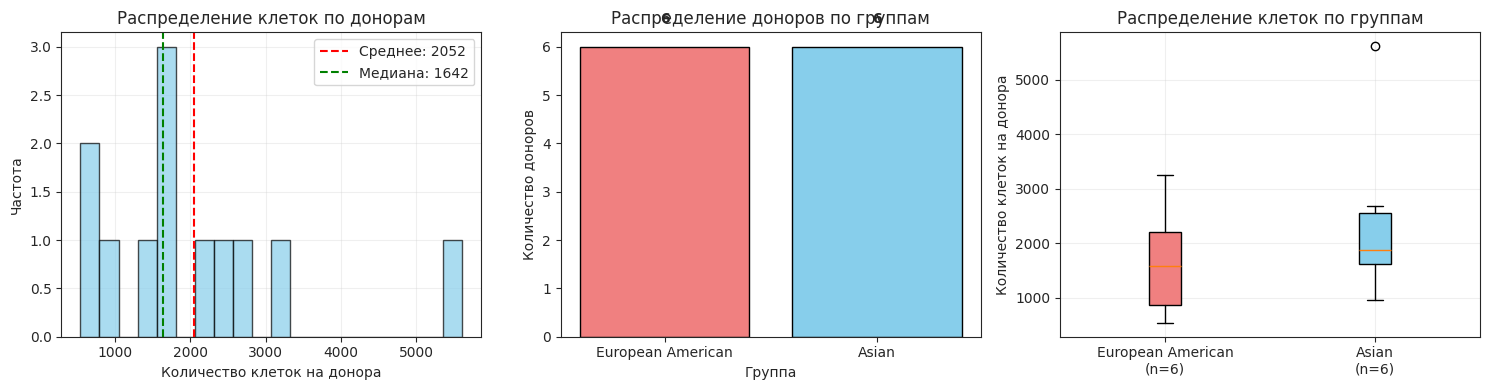

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(cell_counts_filtered['total_cells'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(cell_counts_filtered['total_cells'].mean(), color='red', linestyle='--', label=f'Среднее: {cell_counts_filtered["total_cells"].mean():.0f}')
axes[0].axvline(cell_counts_filtered['total_cells'].median(), color='green', linestyle='--', label=f'Медиана: {cell_counts_filtered["total_cells"].median():.0f}')
axes[0].set_xlabel('Количество клеток на донора')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение клеток по донорам')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if disease_candidates:
    disease_col = disease_candidates
    disease_counts = cell_counts_filtered[disease_col].value_counts()
    colors = ['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(disease_counts)]
    axes[1].bar(disease_counts.index, disease_counts.values, color=colors, edgecolor='black')
    axes[1].set_xlabel('Группа')
    axes[1].set_ylabel('Количество доноров')
    axes[1].set_title('Распределение доноров по группам')
    for i, (idx, val) in enumerate(disease_counts.items()):
        axes[1].text(i, val + 0.5, str(val), ha='center', fontweight='bold')

if disease_candidates:
    import pandas as pd
    disease_col = disease_candidates
    boxplot_data = []
    labels = []
    for condition in cell_counts_filtered[disease_col].unique():
        condition_data = cell_counts_filtered[cell_counts_filtered[disease_col] == condition]['total_cells']
        boxplot_data.append(condition_data)
        labels.append(f"{condition}\n(n={len(condition_data)})")

    bp = axes[2].boxplot(boxplot_data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(boxplot_data)]):
        patch.set_facecolor(color)
    axes[2].set_ylabel('Количество клеток на донора')
    axes[2].set_title('Распределение клеток по группам')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('donor_filtering_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
cell_counts_filtered.to_csv('cell_counts_for_analysis.csv', index=False)

donor_metadata = cell_counts_filtered[['donor_id', 'self_reported_ethnicity']].copy()
donor_metadata.to_csv('donor_metadata.csv', index=False)

cell_type_descriptions = pd.DataFrame({
    'cell_type': cell_counts_filtered.columns[2:-1] if 'total_cells' in cell_counts_filtered.columns else cell_counts_filtered.columns[2:]
})
cell_type_descriptions.to_csv('cell_type_descriptions.csv', index=False)

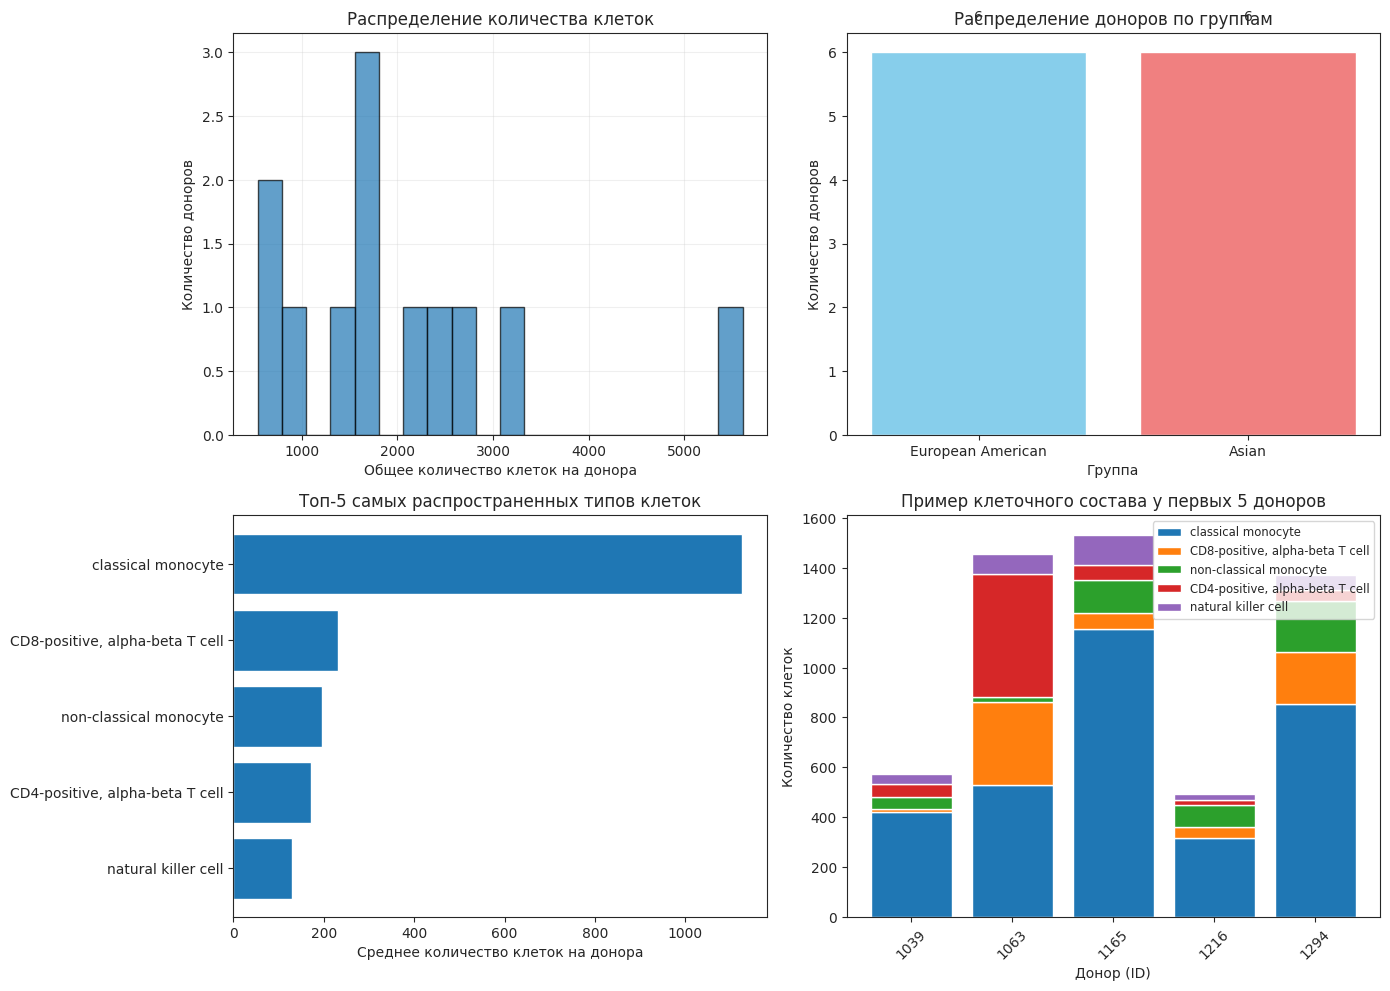

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Распределение общего количества клеток по донорам
axes[0, 0].hist(cell_counts_filtered['total_cells'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Общее количество клеток на донора')
axes[0, 0].set_ylabel('Количество доноров')
axes[0, 0].set_title('Распределение количества клеток')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Количество доноров в каждой группе
group_counts = cell_counts_filtered['self_reported_ethnicity'].value_counts()
axes[0, 1].bar(group_counts.index, group_counts.values, color=['skyblue', 'lightcoral'])
axes[0, 1].set_xlabel('Группа')
axes[0, 1].set_ylabel('Количество доноров')
axes[0, 1].set_title('Распределение доноров по группам')
for i, v in enumerate(group_counts.values):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center')

# График 3: Топ-5 самых распространенных типов клеток (среднее по всем донорам)
mean_composition = cell_counts_filtered.iloc[:, 2:-1].mean().sort_values(ascending=False).head(5)
axes[1, 0].barh(range(len(mean_composition)), mean_composition.values)
axes[1, 0].set_yticks(range(len(mean_composition)))
axes[1, 0].set_yticklabels(mean_composition.index)
axes[1, 0].set_xlabel('Среднее количество клеток на донора')
axes[1, 0].set_title('Топ-5 самых распространенных типов клеток')
axes[1, 0].invert_yaxis()

# График 4: Пример композиции для нескольких доноров (первые 5)
sample_donors = cell_counts_filtered.head(5)
x = range(len(sample_donors))
bottom = np.zeros(len(sample_donors))

# Берем топ-5 типов клеток по распространенности
top_cell_types = mean_composition.index.tolist()

for i, cell_type in enumerate(top_cell_types):
    if cell_type in sample_donors.columns:
        axes[1, 1].bar(x, sample_donors[cell_type], bottom=bottom, label=cell_type)
        bottom += sample_donors[cell_type].values

axes[1, 1].set_xlabel('Донор (ID)')
axes[1, 1].set_ylabel('Количество клеток')
axes[1, 1].set_title('Пример клеточного состава у первых 5 доноров')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(sample_donors['donor_id'].tolist(), rotation=45)
axes[1, 1].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.savefig('data_quality_check.png', dpi=150, bbox_inches='tight')
plt.show()

In [27]:
proportions = cell_counts_filtered.copy()
cell_type_columns = [col for col in proportions.columns
                     if col not in ['donor_id', 'self_reported_ethnicity', 'total_cells']]

for col in cell_type_columns:
    proportions[col] = proportions[col] / proportions['total_cells']

proportions.to_csv('cell_proportions_for_ttest.csv', index=False)

group_asian = proportions[proportions['self_reported_ethnicity'] == 'Asian']
group_white = proportions[proportions['self_reported_ethnicity'] == 'European American']

In [28]:
proportions

cell_type,donor_id,self_reported_ethnicity,B cell,lymphocyte,natural killer cell,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",plasmacytoid dendritic cell,classical monocyte,non-classical monocyte,plasmablast,conventional dendritic cell,progenitor cell,total_cells
0,1039,European American,0.022936,0.012232,0.059633,0.081040,0.018349,0.032110,0.643731,0.073394,0.021407,0.030581,0.004587,654
2,1063,European American,0.080918,0.005435,0.047705,0.297101,0.202295,0.006643,0.318237,0.013285,0.001812,0.023551,0.003019,1656
5,1165,Asian,0.012907,0.020283,0.075599,0.036878,0.040565,0.002459,0.708666,0.081131,0.005532,0.012293,0.003688,1627
6,1216,European American,0.001859,0.014870,0.044610,0.035316,0.087361,0.003717,0.585502,0.161710,0.000000,0.061338,0.003717,538
9,1294,Asian,0.099629,0.018564,0.036510,0.027228,0.129950,0.008663,0.527228,0.128094,0.000619,0.022277,0.001238,1616
11,1334,Asian,0.053446,0.001875,0.012658,0.008439,0.051571,0.001875,0.800281,0.011721,0.000469,0.055321,0.002344,2133
13,1420,Asian,0.035316,0.025651,0.091450,0.077323,0.166914,0.005204,0.456506,0.092193,0.002974,0.043866,0.002602,2690
14,1558,European American,0.027197,0.004603,0.058159,0.064854,0.039331,0.004184,0.596653,0.179079,0.000418,0.023849,0.001674,2390
16,1730,European American,0.055592,0.006618,0.059563,0.070814,0.151555,0.001324,0.528789,0.041694,0.003309,0.080079,0.000662,1511
19,1881,Asian,0.043979,0.024084,0.141361,0.078534,0.162304,0.003141,0.381152,0.147644,0.004188,0.012565,0.001047,955


In [29]:
print("Доступные колонки в cell_counts:")
print(cell_counts_filtered.columns.tolist())

ethnicity = 'self_reported_ethnicity'

service_cols = ['donor_id', 'total_cells']
if ethnicity:
    service_cols.append(ethnicity)

cell_type_cols = [col for col in cell_counts_filtered.columns if col not in service_cols]

sccoda_df = cell_counts_filtered[cell_type_cols + [ethnicity]].copy()


adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["self_reported_ethnicity"]
)

adata_sccoda.write('cell_counts_sccoda.h5ad', compression='gzip')
sccoda_csv = cell_counts_filtered[['donor_id'] + cell_type_cols + [ethnicity]].copy()
sccoda_csv.to_csv('cell_counts_sccoda_format.csv', index=False)


if 'cell_counts_sccoda_format.csv' in globals() or 'sccoda_df' in globals():
    sample_data = sccoda_df.head(3) if 'sccoda_df' in globals() else pd.read_csv('cell_counts_sccoda_format.csv').head(3)

    if len(cell_type_cols) > 5:
        show_cols = cell_type_cols[:3] + ['...'] + cell_type_cols[-2:] + ['self_reported_ethnicity']
    else:
        show_cols = cell_type_cols + ['self_reported_ethnicity']

    for idx, row in sample_data.iterrows():
        if len(cell_type_cols) > 5:
            first_types = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols[:2]])
            last_types = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols[-2:]])
            print(f"Донор {idx+1}: {first_types}, ..., {last_types}, Условие: {row['self_reported_ethnicity']}")
        else:
            types_str = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols])
            print(f"Донор {idx+1}: {types_str}, Условие: {row['self_reported_ethnicity']}")

Доступные колонки в cell_counts:
['donor_id', 'self_reported_ethnicity', 'B cell', 'lymphocyte', 'natural killer cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'plasmacytoid dendritic cell', 'classical monocyte', 'non-classical monocyte', 'plasmablast', 'conventional dendritic cell', 'progenitor cell', 'total_cells']
Донор 1: B cell: 15, lymphocyte: 8, ..., conventional dendritic cell: 20, progenitor cell: 3, Условие: European American
Донор 3: B cell: 134, lymphocyte: 9, ..., conventional dendritic cell: 39, progenitor cell: 5, Условие: European American
Донор 6: B cell: 21, lymphocyte: 33, ..., conventional dendritic cell: 20, progenitor cell: 6, Условие: Asian


In [30]:
sccoda_csv

cell_type,donor_id,B cell,lymphocyte,natural killer cell,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",plasmacytoid dendritic cell,classical monocyte,non-classical monocyte,plasmablast,conventional dendritic cell,progenitor cell,self_reported_ethnicity
0,1039,15,8,39,53,12,21,421,48,14,20,3,European American
2,1063,134,9,79,492,335,11,527,22,3,39,5,European American
5,1165,21,33,123,60,66,4,1153,132,9,20,6,Asian
6,1216,1,8,24,19,47,2,315,87,0,33,2,European American
9,1294,161,30,59,44,210,14,852,207,1,36,2,Asian
11,1334,114,4,27,18,110,4,1707,25,1,118,5,Asian
13,1420,95,69,246,208,449,14,1228,248,8,118,7,Asian
14,1558,65,11,139,155,94,10,1426,428,1,57,4,European American
16,1730,84,10,90,107,229,2,799,63,5,121,1,European American
19,1881,42,23,135,75,155,3,364,141,4,12,1,Asian


t-test analysis:

In [31]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

proportions = pd.read_csv('cell_counts_for_analysis.csv', index_col=0)
metadata = pd.read_csv('donor_metadata.csv')

analysis_df = proportions.merge(
    metadata,
    left_index=True,
    right_on='donor_id',
    suffixes=('_prop', '_meta')
)

cell_type_columns = [col for col in proportions.columns
                     if col not in ['self_reported_ethnicity', 'total_cells']]

group_col = 'self_reported_ethnicity_prop'
groups = analysis_df[group_col].unique()
if len(groups) == 2:
    group1, group2 = groups[0], groups[1]
    print(f"Сравниваем группы: '{group1}' vs '{group2}'")

    results = []
    for cell_type in cell_type_columns:
        data_group1 = analysis_df[analysis_df[group_col] == group1][cell_type]
        data_group2 = analysis_df[analysis_df[group_col] == group2][cell_type]

        if len(data_group1) >= 3 and len(data_group2) >= 3:
            t_stat, p_val = ttest_ind(data_group1, data_group2, equal_var=False, nan_policy='omit')
            mean_diff = data_group1.mean() - data_group2.mean()
            results.append({
                'cell_type': cell_type,
                'mean_diff': mean_diff,
                't_statistic': t_stat,
                'p_value': p_val
            })

    ttest_results = pd.DataFrame(results)

    if len(ttest_results) > 0:
        ttest_results['p_value_adj'] = multipletests(ttest_results['p_value'], method='fdr_bh')[1]
        ttest_results['significant'] = ttest_results['p_value_adj'] < 0.1

        ttest_results.sort_values('p_value').to_csv('ttest_results.csv', index=False)
        print(f"Значимых типов клеток (FDR < 0.05): {ttest_results['significant'].sum()} из {len(ttest_results)}")

        print("Топ-5 значимых типов клеток по t-test:")
        print(ttest_results[ttest_results['significant']].sort_values('p_value').head(5)[['cell_type', 'mean_diff', 'p_value_adj']])
else:
    print(f"Найдено {len(groups)} групп. Ожидается 2 группы для t-test.")

Сравниваем группы: 'European American' vs 'Asian'
Значимых типов клеток (FDR < 0.05): 0 из 11
Топ-5 значимых типов клеток по t-test:
Empty DataFrame
Columns: [cell_type, mean_diff, p_value_adj]
Index: []


In [32]:
ttest_results

,cell_type,mean_diff,t_statistic,p_value,p_value_adj,significant
0,B cell,-74.833333,-1.490648,0.179546,0.695021,False
1,lymphocyte,-22.000000,-2.536024,0.051359,0.564944,False
2,natural killer cell,-80.666667,-1.258037,0.252735,0.695021,False
3,"CD4-positive, alpha-beta T cell",-24.333333,-0.192644,0.851674,0.936842,False
4,"CD8-positive, alpha-beta T cell",-191.000000,-1.290820,0.242312,0.695021,False
5,plasmacytoid dendritic cell,1.833333,0.305721,0.766313,0.936842,False
6,classical monocyte,-344.666667,-0.813029,0.435135,0.936842,False
7,non-classical monocyte,-49.166667,-0.464028,0.652571,0.936842,False
8,plasmablast,0.000000,0.000000,1.000000,1.000000,False
9,conventional dendritic cell,11.166667,0.329589,0.749120,0.936842,False


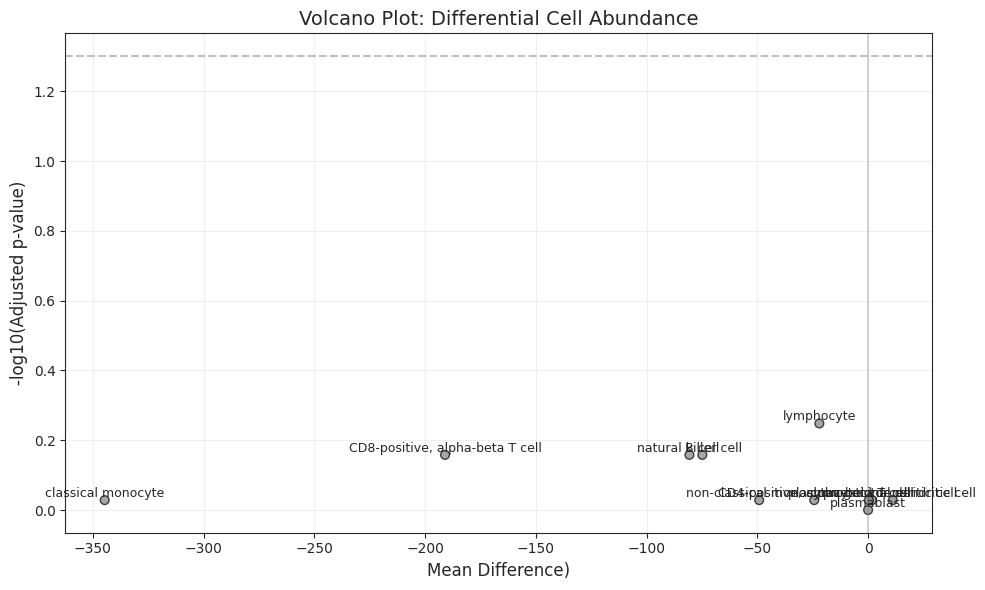

In [33]:
plt.figure(figsize=(10, 6))

colors = ['red' if sig else 'gray' for sig in ttest_results['significant']]
sizes = [80 if sig else 40 for sig in ttest_results['significant']]

plt.scatter(ttest_results['mean_diff'],
            -np.log10(ttest_results['p_value_adj']),
            c=colors, s=sizes, alpha=0.7, edgecolors='black')

for i, row in ttest_results.iterrows():
    plt.text(row['mean_diff'],
             -np.log10(row['p_value_adj']),
             row['cell_type'],
             fontsize=9, ha='center', va='bottom')

plt.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='-', alpha=0.3)

plt.xlabel('Mean Difference)', fontsize=12)
plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
plt.title('Volcano Plot: Differential Cell Abundance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volcano_plot.png', dpi=300)
plt.show()

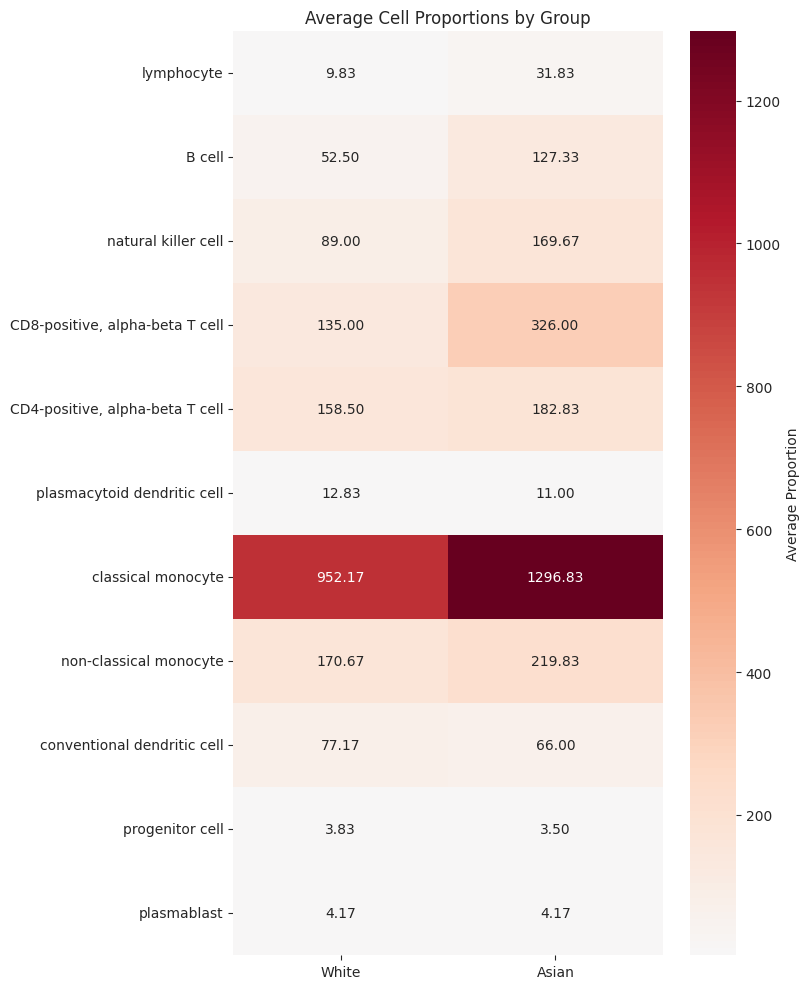

In [34]:
top_cells = ttest_results.sort_values('p_value_adj').head(15)['cell_type'].tolist()

group_means = pd.DataFrame({
    'White': analysis_df[analysis_df[group_col] == group1][top_cells].mean(),
    'Asian': analysis_df[analysis_df[group_col] == group2][top_cells].mean()
})

plt.figure(figsize=(8, 10))
sns.heatmap(group_means,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Average Proportion'})
plt.title('Average Cell Proportions by Group')
plt.tight_layout()
plt.savefig('heatmap_group_means.png', dpi=300)
plt.show()

scCODA analysis:

In [35]:
counts_df = pd.read_csv('cell_counts_sccoda_format.csv', index_col=0)
metadata_df = pd.read_csv('donor_metadata.csv').set_index('donor_id')

if 'self_reported_ethnicity' in metadata_df.columns:
    metadata_df = metadata_df.rename(columns={'self_reported_ethnicity': 'group'})

cols_to_drop = ['self_reported_ethnicity', 'total_cells', 'cell_type']
existing_cols = [col for col in cols_to_drop if col in counts_df.columns]
if existing_cols:
    counts_df = counts_df.drop(columns=existing_cols)

sccoda_df = counts_df.join(metadata_df, how='inner')

adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["group"]
)

In [36]:
sccoda_df

,B cell,lymphocyte,natural killer cell,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",plasmacytoid dendritic cell,classical monocyte,non-classical monocyte,plasmablast,conventional dendritic cell,progenitor cell,group
donor_id,,,,,,,,,,,,
1039,15,8,39,53,12,21,421,48,14,20,3,European American
1063,134,9,79,492,335,11,527,22,3,39,5,European American
1165,21,33,123,60,66,4,1153,132,9,20,6,Asian
1216,1,8,24,19,47,2,315,87,0,33,2,European American
1294,161,30,59,44,210,14,852,207,1,36,2,Asian
1334,114,4,27,18,110,4,1707,25,1,118,5,Asian
1420,95,69,246,208,449,14,1228,248,8,118,7,Asian
1558,65,11,139,155,94,10,1426,428,1,57,4,European American
1730,84,10,90,107,229,2,799,63,5,121,1,European American


In [37]:
model = mod.CompositionalAnalysis(
    data=adata_sccoda,
    formula="group",
    reference_cell_type="automatic"
)

results = model.sample_hmc()

results.save("sccoda_results")

Automatic reference selection! Reference cell type set to lymphocyte
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:37<00:00, 92.05it/s]


MCMC sampling finished. (270.240 sec)
Acceptance rate: 57.3%


In [38]:
print("Краткие результаты scCODA:")
summary = results.summary()
print(summary)

credible_effects = results.credible_effects()
print(f"Значимо измененные типы клеток (вероятность > 0.95): {credible_effects.sum()}")

Краткие результаты scCODA:
Compositional Analysis summary:

Data: 12 samples, 11 cell types
Reference index: 1
Formula: group

Intercepts:
                                 Final Parameter  Expected Sample
Cell Type                                                        
B cell                                     0.372        87.135693
lymphocyte                                -0.380        41.077749
natural killer cell                        0.824       136.929554
CD4-positive, alpha-beta T cell            0.812       135.296219
CD8-positive, alpha-beta T cell            1.203       200.029846
plasmacytoid dendritic cell               -0.697        29.918188
classical monocyte                         2.929      1123.794953
non-classical monocyte                     1.062       173.723784
plasmablast                               -1.111        19.775951
conventional dendritic cell                0.346        84.899363
progenitor cell                           -1.108        19.835368


E

<Axes: xlabel='Cell type', ylabel='Proportion'>

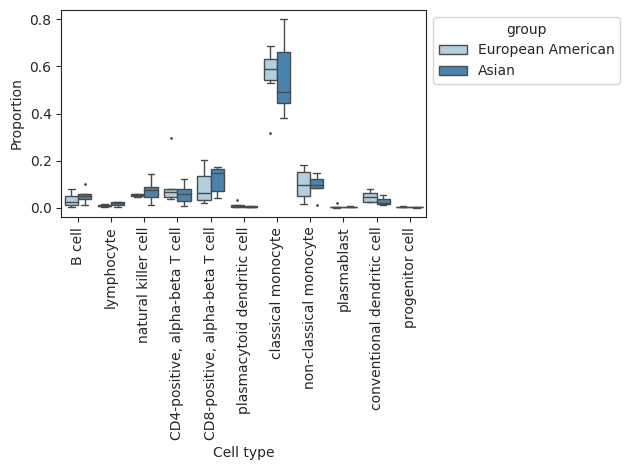

In [39]:
viz.boxplots(adata_sccoda, feature_name="group")

Опять видим отсутствие значимых изменений.